In [2]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

In [3]:
bts = pd.read_csv('../data/bts.csv')
meds_train_alunos = pd.read_csv('../data/meds_train_alunos.csv')

In [4]:
X = meds_train_alunos[['rssi_1_1', 'rssi_1_2', 'rssi_1_3', 'rssi_2_1', 'rssi_2_2', 'rssi_2_3', 'rssi_3_1', 'rssi_3_2', 'rssi_3_3']]

y = meds_train_alunos[['lat', 'lon']]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
k = 3  # Número de vizinhos
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

## Resultados

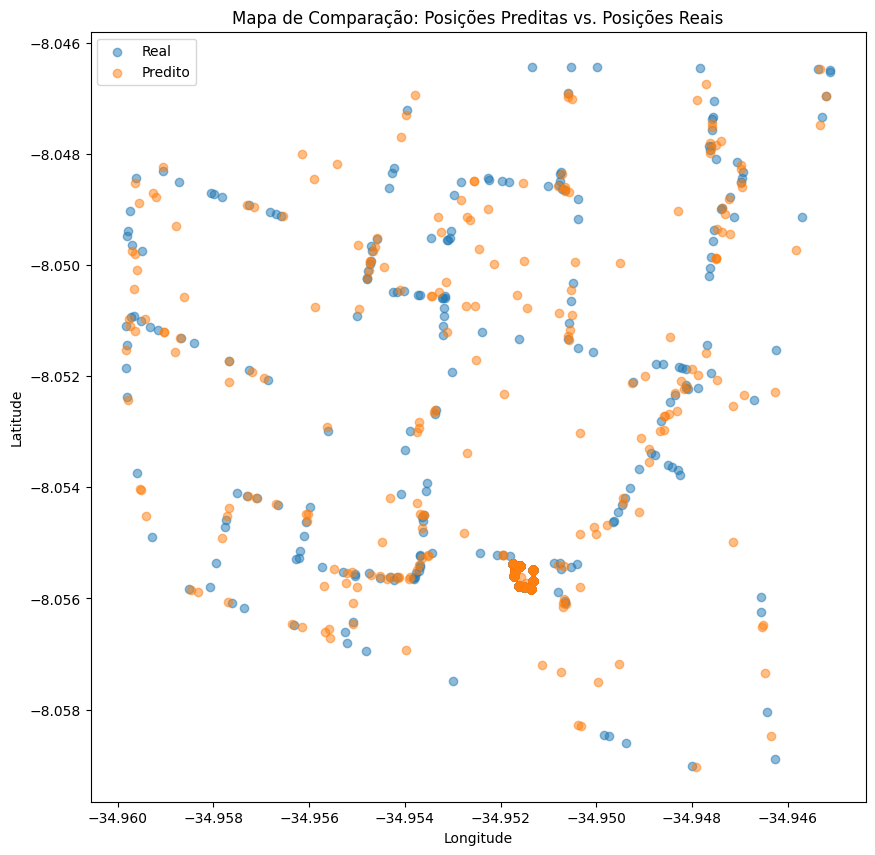

In [23]:
y_pred_array = np.array(y_pred)

plt.figure(figsize=(10, 10))
plt.scatter(y_test['lon'], y_test['lat'], label='Real', alpha=0.5)
plt.scatter(y_pred_array[:, 1], y_pred_array[:, 0], label='Predito', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Posições Preditas vs. Posições Reais')
plt.legend()
plt.show()

In [9]:
y_test_subset = y_test[['lat', 'lon']]

mse = mean_squared_error(y_test_subset, y_pred_array)
mae = mean_absolute_error(y_test_subset, y_pred_array)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 4.2601534660752285e-07
Mean Absolute Error (MAE): 0.00016452261553593798


## Gerar submit file

In [30]:
meds_test = pd.read_csv('../data/meds_test_alunos.csv')

In [35]:
X_test = meds_test[['rssi_1_1', 'rssi_1_2', 'rssi_1_3', 'rssi_2_1', 'rssi_2_2', 'rssi_2_3', 'rssi_3_1', 'rssi_3_2', 'rssi_3_3']]

y_pred_test = knn.predict(X_test)

In [36]:
submit_df = pd.DataFrame({'ponto_id': meds_test['ponto_id'], 'lat_pred': y_pred_test[:, 0], 'lon_pred': y_pred_test[:, 1]})
submit_df.to_csv('../submit_files/knn_submit_alunos.csv', index=False)